In [3]:
import surprise
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)

In [2]:
data = pd.read_csv('Data/data_for_collab.csv')

In [3]:
reviews_res = pd.read_csv('Data/USres_reviews_2.csv')

In [4]:
data.head()

,user_id,business_id,stars
0,---1lKK3aKOuomHnwAkAow,--9e1ONYQuAa-CB_Rrw7Tw,4.0
1,---1lKK3aKOuomHnwAkAow,7vHvQCjPq5pWj7Rio1A--w,1.0
2,---1lKK3aKOuomHnwAkAow,A0X1baHPgw9IiBRivu0G9g,5.0
3,---1lKK3aKOuomHnwAkAow,AZlnpvILz5cEWJifjr2CSQ,5.0
4,---1lKK3aKOuomHnwAkAow,GJBLjDkfJ4tvkpAjDeCikA,1.0


In [5]:
#Create id for user_id and business_id

def generate_id_dict(list_old_id):
    #Generate a look up dataframe for user_id
    new_id = np.arange(len(list_old_id))
    #Create a lookup dictionary
    id_lookup = pd.DataFrame({'old_id': list_old_id,
                                'new_id': new_id})
    return id_lookup

#Generate user_id for reviews

list_user_id = data.user_id.unique().tolist()
user_id_lookup = generate_id_dict(list_user_id)

#Generate item_id for reviews
list_bus_id = data.business_id.unique().tolist()
bus_id_lookup = generate_id_dict(list_bus_id)

print ("Number of users: ", user_id_lookup.shape[0])
print ('Number of items: ', bus_id_lookup.shape[0])

Number of users:  24512
Number of items:  16906


In [6]:
data = data.merge(bus_id_lookup, left_on = 'business_id', right_on = 'old_id', how = 'left')
data = data.merge(user_id_lookup, left_on = 'user_id', right_on = 'old_id', how = 'left')
data.head()

,user_id,business_id,stars,old_id_x,new_id_x,old_id_y,new_id_y
0,---1lKK3aKOuomHnwAkAow,--9e1ONYQuAa-CB_Rrw7Tw,4.0,--9e1ONYQuAa-CB_Rrw7Tw,0,---1lKK3aKOuomHnwAkAow,0
1,---1lKK3aKOuomHnwAkAow,7vHvQCjPq5pWj7Rio1A--w,1.0,7vHvQCjPq5pWj7Rio1A--w,1,---1lKK3aKOuomHnwAkAow,0
2,---1lKK3aKOuomHnwAkAow,A0X1baHPgw9IiBRivu0G9g,5.0,A0X1baHPgw9IiBRivu0G9g,2,---1lKK3aKOuomHnwAkAow,0
3,---1lKK3aKOuomHnwAkAow,AZlnpvILz5cEWJifjr2CSQ,5.0,AZlnpvILz5cEWJifjr2CSQ,3,---1lKK3aKOuomHnwAkAow,0
4,---1lKK3aKOuomHnwAkAow,GJBLjDkfJ4tvkpAjDeCikA,1.0,GJBLjDkfJ4tvkpAjDeCikA,4,---1lKK3aKOuomHnwAkAow,0


In [7]:
#Clean column names
data.rename(columns = {'new_id_x': 'item_id',
                      'new_id_y': 'user_id2'}, inplace = True)

In [8]:
#Create final matrix for model
data_final = data[['user_id2','item_id','stars']]
data_final.shape

(823199, 3)

In [2]:
#Save data_final to disk
data_final.to_csv('Data/yelp_dataset/final_data_for_collab.csv', index = False)

## SVD Model

In [4]:
#Load data
data_final = pd.read_csv('Data/final_data_for_collab.csv')
data_final.shape

(823199, 3)

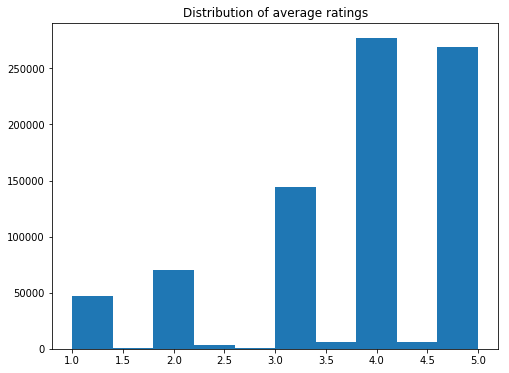

In [5]:
plt.hist(data_final.stars);
plt.title('Distribution of average ratings');

In [6]:
# Set up data
from surprise import Reader, Dataset

reader = Reader(rating_scale=(1.0, 5.0))

data_surprise = Dataset.load_from_df(data_final[['user_id2', 'item_id', 'stars']], reader)

In [7]:
#Train-test split
from surprise.model_selection import train_test_split

trainset, testset = train_test_split(data_surprise, test_size=.25)


In [8]:
print ("Train set has {} ratings, {} userID, {} itemID".format(trainset.n_ratings, trainset.n_users, trainset.n_items))
print ('All data has {} ratings, {} userID, {} itemID'.format(data_final.shape[0], data_final.user_id2.nunique(),
                                                             data_final.item_id.nunique()) )

Train set has 617399 ratings, 24512 userID, 16882 itemID
All data has 823199 ratings, 24512 userID, 16906 itemID


In [9]:
# Base model
from surprise import SVD
from surprise import accuracy

algo = SVD()
algo.fit(trainset)

predictions = algo.test(testset)

# Compute RMSE
accuracy.rmse(predictions)

RMSE: 1.0472


1.0471500946629444

In [12]:
algo2 = SVD(n_epochs = 30, lr_all = 0.003, reg_all = 0.1)
algo2.fit(trainset)

predictions2 = algo2.test(testset)

# Compute RMSE
accuracy.rmse(predictions2)

RMSE: 1.0376


1.0376031538381916

In [50]:
data_final.stars.describe()

count    823199.000000
mean          3.801345
std           1.155394
min           1.000000
25%           3.000000
50%           4.000000
75%           5.000000
max           5.000000
Name: stars, dtype: float64

In [43]:
#Fine tuning the model

from surprise.model_selection import GridSearchCV

param_grid = {'n_epochs': [10, 20,30], 'lr_all': [0.002, 0.005, 0.003],
              'reg_all': [0.02, 0.1 ,0.4]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data_surprise)


In [44]:
# best RMSE score and MAE score
print('Best RMSE score: ',gs.best_score['rmse'])
print ("Best MAE score: ", gs.best_score['mae'])

# combination of parameters that gave the best scores
print ('Best params for RMSE')
print(gs.best_params['rmse'])
print ('Best params for MAE')
print (gs.best_params['mae'])

Best RMSE score:  1.0377030569479875
Best MAE score:  0.8128760236902274
Best params for RMSE
{'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.1}
Best params for MAE
{'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.1}


In [14]:
# Use the best parameters
# algo_best = gs.best_estimator['rmse']
algo_best = SVD(n_epochs = 20, lr_all = 0.005, reg_all = 0.1)

algo_best.fit(trainset)

predictions_best = algo_best.test(testset)

# Compute RMSE
accuracy.rmse(predictions_best)

RMSE: 1.0372


1.0371756721432814

In [15]:
predictions_best[:10]

[Prediction(uid=1625, iid=7597, r_ui=2.0, est=3.6278156052699497, details={'was_impossible': False}),
 Prediction(uid=13074, iid=20, r_ui=3.0, est=3.445513907528502, details={'was_impossible': False}),
 Prediction(uid=8814, iid=14486, r_ui=4.0, est=3.8331713944213326, details={'was_impossible': False}),
 Prediction(uid=11979, iid=7620, r_ui=4.0, est=4.544402402392421, details={'was_impossible': False}),
 Prediction(uid=23972, iid=1083, r_ui=2.0, est=2.651630115407682, details={'was_impossible': False}),
 Prediction(uid=8674, iid=5722, r_ui=5.0, est=4.20340745778327, details={'was_impossible': False}),
 Prediction(uid=12308, iid=11853, r_ui=4.0, est=3.867369237135575, details={'was_impossible': False}),
 Prediction(uid=21240, iid=13944, r_ui=3.0, est=3.8644156364182116, details={'was_impossible': False}),
 Prediction(uid=1462, iid=3577, r_ui=5.0, est=3.7095463201129144, details={'was_impossible': False}),
 Prediction(uid=8029, iid=7133, r_ui=3.0, est=3.7790476407848814, details={'was_im